In [1]:
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from scipy import ndimage
import sensie

In [2]:
cifar10 = tf.keras.datasets.cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def fade(x, amount):
    return x*(1-amount)

def blur(x, sigma):
    blurred = ndimage.gaussian_filter(x, sigma=sigma/10)
    return blurred


In [4]:
def make_model_cifar10():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same',
                     input_shape=(32, 32, 3)))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(32, (3, 3)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64, (3, 3)))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(512))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    model.add(layers.Activation('softmax'))
    
    return model

In [5]:
# Train

batch_size = 32
num_classes = 10
epochs = 100

model = make_model_cifar10()

opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [6]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
model.fit(X_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(X_test, y_test),
      shuffle=True)



Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 188us/sample - loss: 1.8170 - accuracy: 0.3330 - val_loss: 1.5004 - val_accuracy: 0.4586
Epoch 2/100
50000/50000 [==============================] - 8s 154us/sample - loss: 1.4661 - accuracy: 0.4704 - val_loss: 1.3423 - val_accuracy: 0.5183
Epoch 3/100
50000/50000 [==============================] - 8s 154us/sample - loss: 1.3285 - accuracy: 0.5242 - val_loss: 1.2439 - val_accuracy: 0.5583
Epoch 4/100
50000/50000 [==============================] - 8s 161us/sample - loss: 1.2409 - accuracy: 0.5595 - val_loss: 1.2162 - val_accuracy: 0.5707
Epoch 5/100
50000/50000 [==============================] - 8s 155us/sample - loss: 1.1651 - accuracy: 0.5892 - val_loss: 1.0688 - val_accuracy: 0.6283
Epoch 6/100
50000/50000 [==============================] - 8s 157us/sample - loss: 1.0961 - accuracy: 0.6137 - val_loss: 1.0152 - val_accuracy: 0.6468
Epoch 7/100
50000/50000 [===================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
model.evaluate(X_test, y_test, verbose=2)

10000/10000 - 1s - loss: 0.7362 - accuracy: 0.7745


[0.736199520111084, 0.7745]

In [13]:
(_, y_train_c), (_, y_test_c) = cifar10.load_data()
y_test = y_test_c[:, 0]

Are some classes more difficult for the network than others? This method is a quick way to visualize the confusion. This may be relevant if class and other tested properties are highly correlated.

[########################################] 100% (1/1)    class     

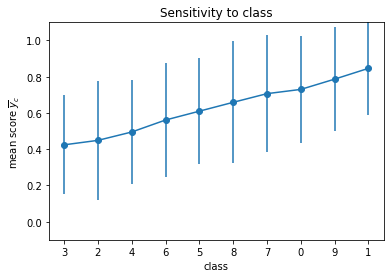

In [14]:
cifar_probe = sensie.Probe(model)
class_test = cifar_probe.test_class_sensitivity(X_test, y_test, plot=True)

In [15]:
class_test.summary()

,sensitivity,significance,sens_50_low,sens_50_high,sens_95_low,sens_95_high
property,,,,,,
class,0.047425,high,NaN,NaN,NaN,NaN


If we make the images darker, how does performance degrade?

[########################################] 100% (20/20)    1.00  

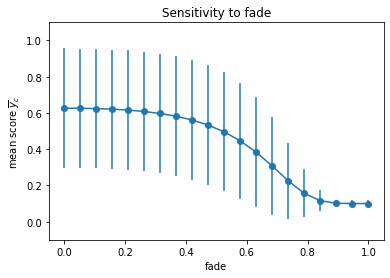

In [16]:
pfunc = fade
fade_test = cifar_probe.predict_and_measure_perturbed(X_test, y_test, pfunc, p_values=None,                                                              
                                      p_min=0, p_max=1, steps=20, label="fade", plot=True)

Yep, not surprisingly once the image fades to black, the accuracy drops to random.

In [35]:
# Highly significant trend
fade_test.summary()

,sensitivity,significance,sens_50_low,sens_50_high,sens_95_low,sens_95_high
property,,,,,,
fade,-0.646622,high,-0.647848,-0.645205,-0.65009,-0.642672


In [18]:
# Let's get some more information on the robustness of that linear fit.
fade_test.get_credible_intervals()
fade_test.summary()

Only 400 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 4 chains: 100%|██████████| 2400/2400 [00:29<00:00, 82.55draws/s] 
The acceptance probability does not match the target. It is 0.8863677932199648, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8926489014789414, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.910883836261704, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9017674568764965, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,sensitivity,significance,sens_50_low,sens_50_high,sens_95_low,sens_95_high
property,,,,,,
fade,-0.646622,high,-0.647848,-0.645205,-0.65009,-0.642672


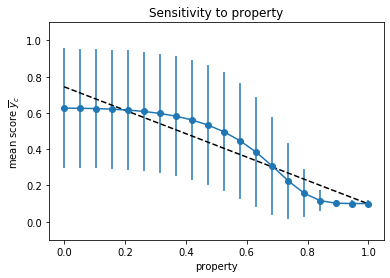

In [19]:
cifar_probe.plot_property(fade_test.tests['fade'], show_fit=True)

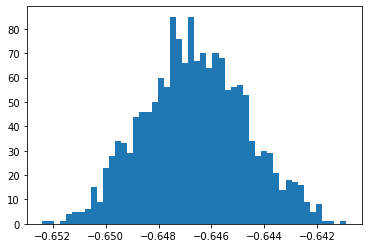

In [20]:
# PDF of significance of the sensitivity
plt.hist(fade_test.tests['fade'].pos['beta'], bins=50);

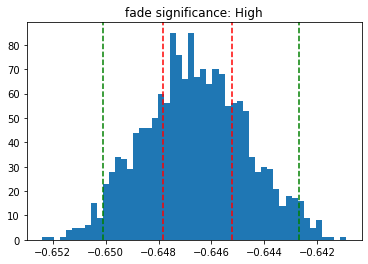

In [37]:
# As we can see it's nowhere near zero.

test = fade_test.tests['fade'].pos['beta']
summary = fade_test.tests['fade'].summary().iloc[0]
min_, max_, mean_ = test.min(), test.max(), test.mean()
plt.hist(test, bins=50)

plt.axvline(summary.sens_50_low, ls="--", color="red")
plt.axvline(summary.sens_50_high, ls="--", color="red")
plt.axvline(summary.sens_95_low, ls="--", color="green")
plt.axvline(summary.sens_95_high, ls="--", color="green")
plt.title(f"fade significance: High");

You can try a polynomial fit; this may allow identification of the most sensitive regions.

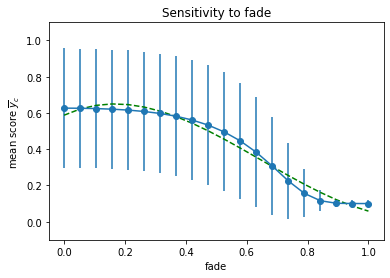

In [38]:
cifar_probe.plot_property(fade_test.tests['fade'], label="fade", show_fit=True, fit="polynomial", fitorder=3)

In [31]:
# Try the blur perturber.
pfunc = blur
blur_test = cifar_probe.predict_and_measure_perturbed(X_test, y_test_c[:, 0], pfunc, p_min=3, p_max=8, steps=20, 
                                   label="blur", plot=False)

[########################################] 100% (20/20)    8.00  

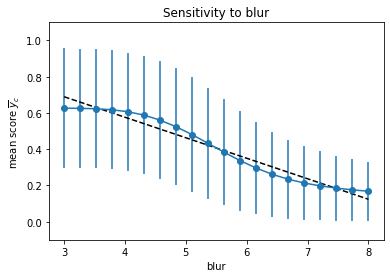

In [32]:
cifar_probe.plot_property(blur_test.tests['blur'], label="blur", show_fit=True)

In [33]:
blur_test.get_credible_intervals()
blur_test.summary()

Only 400 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 4 chains: 100%|██████████| 2400/2400 [00:45<00:00, 52.72draws/s]
The acceptance probability does not match the target. It is 0.9047070385918708, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9174826775638028, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9117615737839683, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9048053994297225, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of eff

,sensitivity,significance,sens_50_low,sens_50_high,sens_95_low,sens_95_high
property,,,,,,
blur,-0.112347,high,-0.113387,-0.112823,-0.114243,-0.106109
